In [1]:
from Network import PINN, NetworkTrainer
from Physics import *
from Physics import NVS

In [2]:
model0 = PINN(width=64, length=12, is_steady=True)

## Define Physical Space

torch.Size([10000])


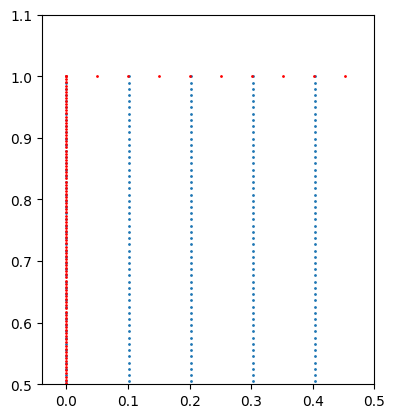

In [39]:
import matplotlib.pyplot as plt
from PointSampling import Bound, PhysicsBound
import torch

bound_list = []
def func1(x):
    return 1*torch.ones_like(x)
bound_list.append(Bound([0,10], func1, True))
def func2(x):
    return 0*torch.ones_like(x)
bound_list.append(Bound([0,10], func2, False))


def func4(y):
    return 0*torch.ones_like(y)
bound_list.append(Bound([0.00001,0.99999], func4, False, ref_axis='y'))
def func5(y):
    return 10*torch.ones_like(y)
bound_list.append(Bound([0,1], func5, True, ref_axis='y'))


X, Y = Bound.sampling_area(bound_list, 100, [0,10], [0,1])
print(X.shape)
xxx = X
yyy = Y
plt.figure()
plt.scatter(X,Y,s=1)
for bound in bound_list:
    x,y = bound.sampling_line(200)
    plt.scatter(x,y,s=1, color='red')
plt.xlim(-0.04,0.5)
plt.ylim(0.5,1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Define Boundary Conditions and PDE Area

In [4]:
physics_cond_list = [
    {'u': 0.0, 'v': 0.0},  # func1: top wall (y=1) -> No-slip
    {'u': 0.0, 'v': 0.0},  # func2: bottom wall (y=0) -> No-slip
    {'u': 0.02, 'v': 0.0},  # func3: inlet (x=0) -> Uniform inflow,
    {'p': 0.0}             # func4: outlet (x=2) -> Zero pressure
]
boundary_conditions_list = []
for i, bound in enumerate(bound_list):
    boundary_conditions_list.append(PhysicsBound.define_boundary_condition(bound, physics_cond_list[i]))

from Physics import NVS
area_physics_bound = PhysicsBound.define_pde_area(bound_list=bound_list, sampling_range_x=[0,10], sampling_range_y=[0,1], PDE_class=NVS(is_steady=True))

### Sampling points

In [5]:
def uniform_sampling():
    for bc in boundary_conditions_list:
        bc.sampling_collocation_points(1000)
    area_physics_bound.sampling_collocation_points(100)

def random_sampling():
    for bc in boundary_conditions_list:
        bc.sampling_collocation_points(400,True)
    area_physics_bound.sampling_collocation_points(40,True)

## Define Physics

In [6]:
loss_fn = torch.nn.MSELoss()
def get_loss():

    random_sampling()

    #bc_loss
    bc_loss = 0
    for bc in boundary_conditions_list:
        bc_loss += bc.calc_loss(model0, loss_fn)

    #pde_loss
    pde_loss = area_physics_bound.calc_loss(model0)

    #total_loss
    total_loss = bc_loss + pde_loss
    
    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [7]:
model1 = NetworkTrainer.train_adam(model=model0, calc_loss=get_loss, learning_rate=0.001, epochs=1500, print_every=100)

epoch 1, total_loss: 0.01038, bc_loss: 0.01038, pde_loss: 0.00000
epoch 101, total_loss: 0.00003, bc_loss: 0.00002, pde_loss: 0.00001
epoch 201, total_loss: 0.00003, bc_loss: 0.00002, pde_loss: 0.00000
epoch 301, total_loss: 0.00003, bc_loss: 0.00002, pde_loss: 0.00001
epoch 401, total_loss: 0.00002, bc_loss: 0.00002, pde_loss: 0.00000
epoch 501, total_loss: 0.00002, bc_loss: 0.00002, pde_loss: 0.00000
epoch 601, total_loss: 0.00002, bc_loss: 0.00002, pde_loss: 0.00000
epoch 701, total_loss: 0.00002, bc_loss: 0.00002, pde_loss: 0.00000
epoch 801, total_loss: 0.00002, bc_loss: 0.00002, pde_loss: 0.00000
epoch 901, total_loss: 0.00002, bc_loss: 0.00002, pde_loss: 0.00000
epoch 1001, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1101, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1201, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1301, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1401, total_loss: 0.00001, bc_loss: 0.00

In [8]:
def random_sampling():
    for bc in boundary_conditions_list:
        bc.sampling_collocation_points(10000,True)
    area_physics_bound.sampling_collocation_points(150,True)

In [9]:
model2 = NetworkTrainer.train_adam(model=model1, calc_loss=get_loss, learning_rate=0.0001, epochs=1000, print_every=100)

epoch 1501, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1601, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1701, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1801, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 1901, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 2001, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 2101, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00000
epoch 2201, total_loss: 0.00001, bc_loss: 0.00001, pde_loss: 0.00000
epoch 2301, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00000
epoch 2401, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00000


In [30]:
model3 = NetworkTrainer.train_adam(model=model2, calc_loss=get_loss, learning_rate=0.0001, epochs=4000, print_every=100)

epoch 2501, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00000
epoch 2601, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 2701, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 2801, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 2901, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3001, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3101, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3201, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3301, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3401, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3501, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3601, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3701, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3801, total_loss: 0.00000, bc_loss: 0.00000, pde_loss: 0.00000
epoch 3901, total_loss: 0.00000, b

# Visualization

In [33]:
from Utility import *
import numpy as np
area_physics_bound.sampling_collocation_points(200)
X,Y,U,V,P,T = area_physics_bound._process_model(model3)
residual = area_physics_bound._get_pde_residual_sum(model3)
X,Y,U,V,P,residual = torch_to_numpy([X,Y,U,V,P,residual])
V_size = np.sqrt(U**2+V**2)


In [34]:
print(P.shape,X.shape)

(40000, 1) (40000, 1)


In [ ]:
points = torch.logspace(0, 1, steps=20)
print(points)
plt


tensor([ 1.0000,  1.1288,  1.2743,  1.4384,  1.6238,  1.8330,  2.0691,  2.3357,
         2.6367,  2.9764,  3.3598,  3.7927,  4.2813,  4.8329,  5.4556,  6.1585,
         6.9519,  7.8476,  8.8587, 10.0000])


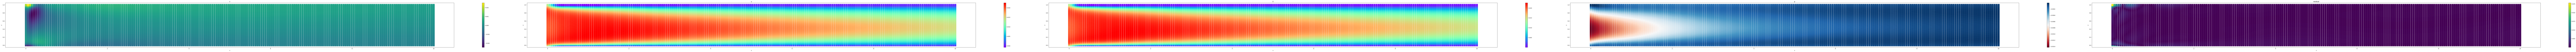

In [32]:
from Visualize import Visualization
import numpy as np
fig, axes = plt.subplots(1,5, figsize=(6*5*10,6))
s =200
Visualization.colorplot(X.flatten(),Y.flatten(),V.flatten(),axes[0],'v','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),U.flatten(),axes[1],'u','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),V_size.flatten(),axes[2],'V','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),P.flatten(),axes[3],'p','RdBu',s)
Visualization.colorplot(X.flatten(),Y.flatten(),residual.flatten(),axes[4],'residual','viridis',s)

plt.tight_layout()
plt.show()

In [35]:
boundary_conditions_list[3].sampling_collocation_points(200)
boundary_conditions_list[3].PDE = NVS()
X,Y,U,V,P,T = boundary_conditions_list[3]._process_model(model1)
X,Y,U,V,P = torch_to_numpy([X,Y,U,V,P])


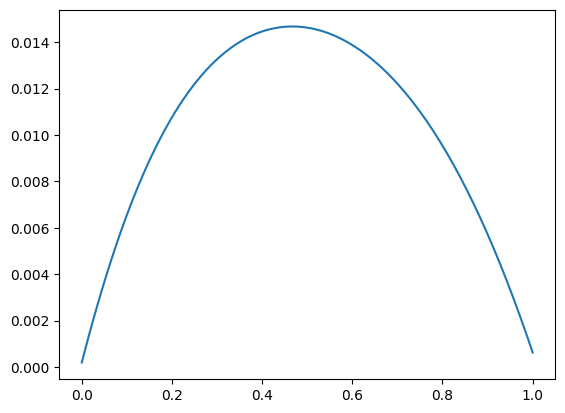

In [36]:
plt.plot(Y.flatten(), U.flatten())
plt.show()

In [37]:
fig.savefig('channel_steady_v2.png')